# Minimal Example 

In [2]:
# imports
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats
import os

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


First, read data (was already pre-processed somewhere else)

In [12]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]  # Repeat as needed

df = pd.read_csv(parent_directory + "\\preprocessedLKOS.csv", index_col = 0)

In [13]:
df
# To do: Find out why the negative values are sometimes after long rows of 0s 


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
2020-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2020-03-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-04,0,0,0,3,0,0,6,1,4,2,...,0,0,0,2,0,0,0,6,43,49
2021-01-05,0,3,2,1,2,0,4,4,30,3,...,2,0,1,0,0,0,0,30,77,107
2021-01-06,2,5,4,4,8,1,5,2,2,8,...,0,0,0,-1,2,1,0,35,89,124
2021-01-07,3,5,1,1,5,4,14,10,10,5,...,0,0,3,4,1,0,-1,46,124,170


# Visualize the data

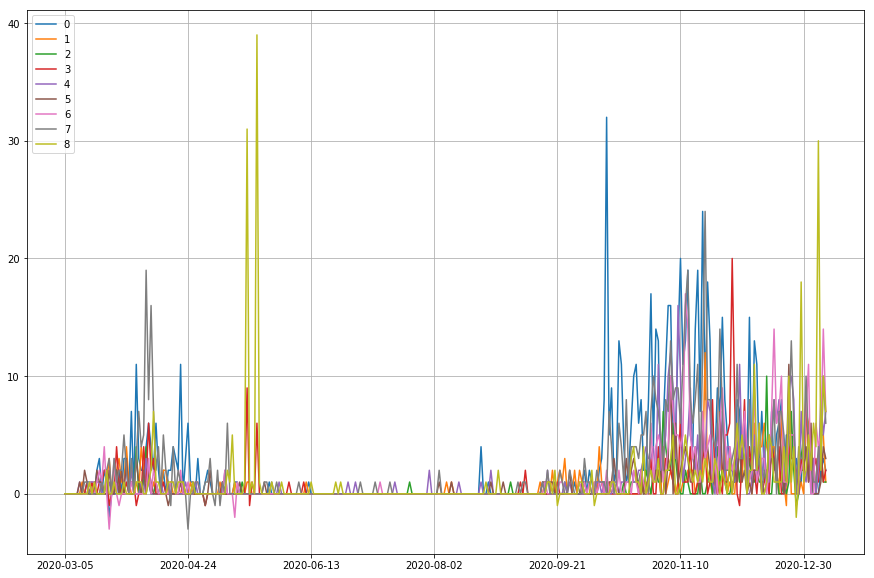

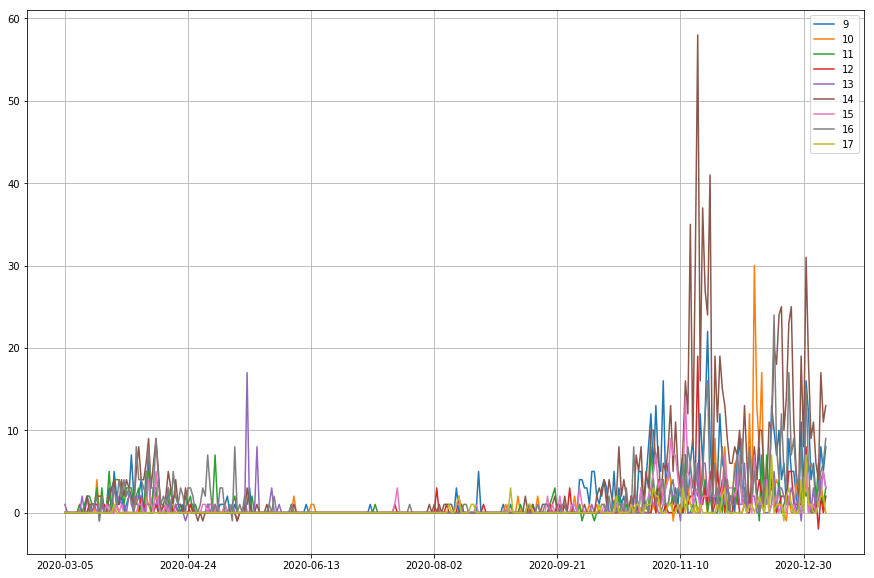

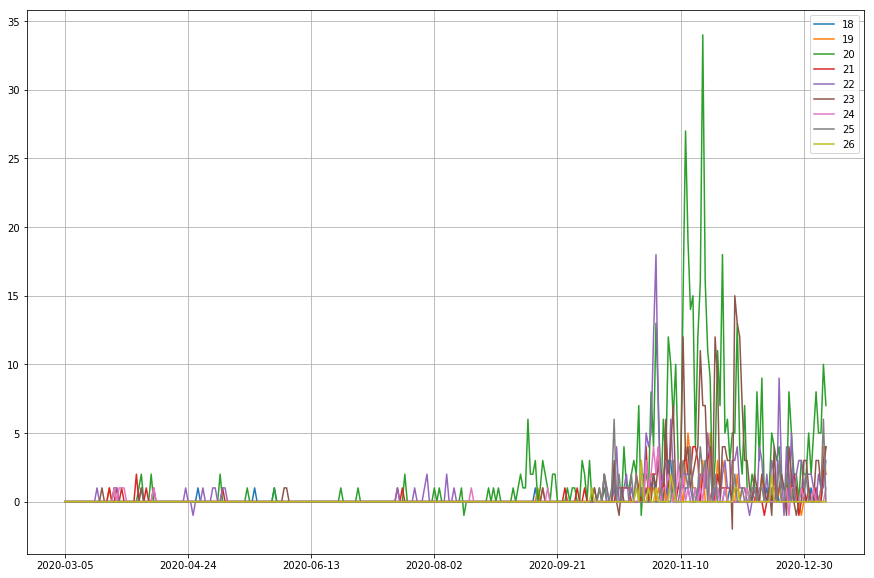

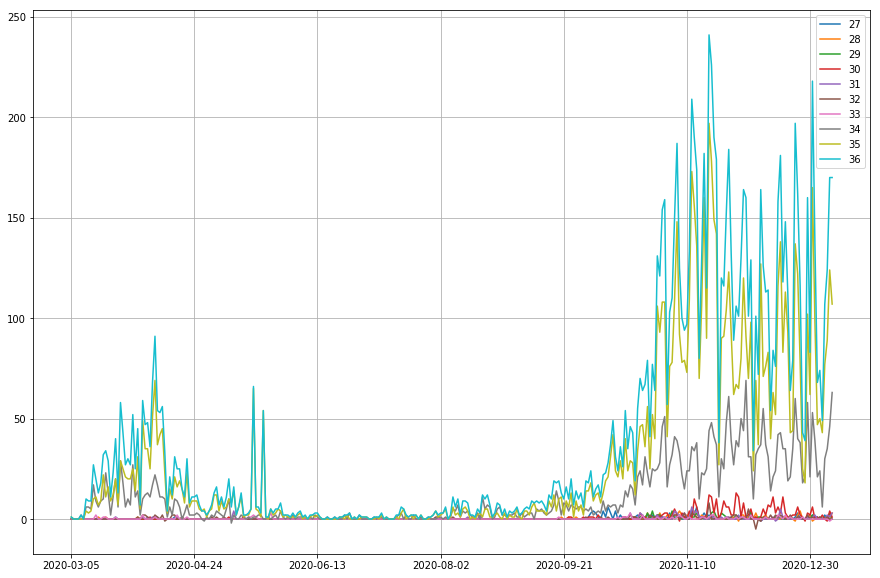

In [32]:
df.iloc[:,:9].plot(grid = True, figsize = (15,10))
df.iloc[:,9:18].plot(grid = True, figsize = (15,10))
df.iloc[:,18:27].plot(grid = True, figsize = (15,10))
df.iloc[:,27:].plot(grid = True, figsize = (15,10))

In [ ]:
# calculate the features based on the classes from original code 
def temporal_polynomial_feature(t, t0, tmax, order):
    scale = (tmax - t0).days # (pd.Datetime - pd.Datetime).days -> differenz in tagen (int)
    t_delta = (t - t0).days / scale

    return t_delta ** order

In [36]:
num_counties = df.shape[1]


37


In [ ]:
with pm.Model() as self.model:
    # priors
    # δ = 1/√α
    δ = pm.HalfCauchy("δ", 10, testval=1.0)
    α = pm.Deterministic("α", np.float32(1.0) / δ)
    
    # weights temporal seasonal 
    W_t_s = pm.Normal(
        "W_t_s", mu=0, sd=10, testval=np.zeros(num_t_s), shape=num_t_s
    )
    
    # weights temporal trend
    W_t_t = pm.Normal(
        "W_t_t",
        mu=0,
        sd=10,
        testval=np.zeros((num_counties, num_t_t)),
        shape=(num_counties, num_t_t),
    )
    # weights temporal_report_delay
    W_t_d = pm.Normal(
        "W_t_d", mu=0, sd=10, testval=np.zeros(num_t_d), shape=num_t_d
    )
    # weights termporal spatial
#     W_ts = pm.Normal(
#         "W_ts", mu=0, sd=10, testval=np.zeros(num_ts), shape=num_ts
#     )

    self.param_names = ["δ", "W_t_s", "W_t_t", "W_t_d"]
    self.params = [δ, W_t_s, W_t_t, W_t_d]

    expanded_Wtt = tt.tile(
        W_t_t.reshape(shape=(1, num_counties, -1)), reps=(21, 1, 1)
    )
    expanded_TT = np.reshape(T_T, newshape=(21, 412, 2))
    result_TT = tt.flatten(tt.sum(expanded_TT * expanded_Wtt, axis=-1))

    # calculate mean rates
    μ = pm.Deterministic(
        "μ",
        tt.exp(
            tt.dot(T_S, W_t_s)
            + result_TT
            + tt.dot(T_D, W_t_d)
            #+ log_exposure
        ),
    )
    # constrain to observations
    pm.NegativeBinomial("Y", mu=μ, alpha=α, observed=Y_obs)